## Creating a convolutional neural network (CNN)

In this notebook, we will import the information stored as numpy arrays and create train/test and validation data sets. As we have imbalanced data due to the high abundance of beech trees in the data set, we will do data augmentation and oversampling. Next, we crate the structure for the models used for classification and look into the results and accuracy of our best model.

While we tested different model structures and number of features, here, we will only report our best model.


**Data you need for running this notebook:**

Zipped numpy arrays (.npz) with all information, that should be added to the model (such as spectral information and vegetation height)

**Content overview:**

* [Setup](#Setup)
* [Data manipulation](#Data-Manipulation)
* [Prepare the data for the model](#Prepare-the-data-for-the-model)
* [Create the Ensemble Convolutional Neural Network Model](#Create-the-Ensemble-Convolutional-Neural-Network-Model)
* [Additional Information](#Additional-Information)

---------

---------

## Setup

In [1]:
# Toolboxes for data handling
import numpy as np
import pandas as pd

# Toolboxes for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Toolboxes for modelling with a neural network
import tensorflow as tf

# Toolboxes for splitting the data
from sklearn.model_selection import train_test_split

# Toolboxes for warning handling
import warnings

2023-10-10 17:08:36.217574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 17:08:36.260276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 17:08:36.261516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 17:08:37.251407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Ignore warnings for this notebook
warnings.filterwarnings("ignore")

## Import and manipulate data 

Basis for the modelling are the box images, that have been stored as zipped numpy arrays

In [3]:
# Define paths to the data
path_spec = './data/TDOP/box_images/TDOP_box_images_2022_weg30m.tif.npz'
path_height = './data/LiDAR/box_images/vegheight_box_images_weg30m.tif.npz'
path_slope = './data/LiDAR/box_images/slope_box_images_weg30m.tif.npz'
path_altitude = './data/LiDAR/box_images/altitude_box_images_weg30m.tif.npz'
path_label = './data/Laubbäume_utm32_cleaned.csv'

# Load spectral data
with np.load(path_spec, allow_pickle=True) as data:
    bia_spec = data["bia_array"]

# Load vegetation height data
with np.load(path_height, allow_pickle=True) as data:
    bia_height = data["bia_array"]

# Load slope data
with np.load(path_slope, allow_pickle=True) as data:
    bia_slope = data["bia_array"]

# Load altitude data
with np.load(path_altitude, allow_pickle=True) as data:
    bia_altitude = data["bia_array"]

# Load label data, extract only the labels and transform the vector
# to an array
lbl_array_tmp = np.array(pd.read_csv(path_label).desc)

---------

---------

## Data manipulation

### Detect weird occurrences in the data and drop them

In [4]:
# Determine weird values in the spectral data
# np.unique(bia_spec, return_counts=True)

# The spectral data range between 5250 and 65250 but there are
# 11552 occurrences with a 0 matching exactly two images 38*38*4

# Create identifier for these occurrences
ind_spec = np.all(bia_spec == 0, (1,2,3))

In [5]:
# Determine weird values in the height data
# np.unique(bia_height, return_counts=True)

# The height data range between .05 and 44.15 but there are
# 200 occurrences with a 0 matching exactly two images 10*10*1

# Create identifier for these occurrences
ind_height = np.all(bia_height == 0, (1,2))

In [6]:
# Determine weird values in the slope data
# np.unique(bia_slope, return_counts=True)

# The slope ranges between 10 and 85° but there are two occurrences of
# -9999 and three with 0

# Create identifier for these occurrences
ind_slope = bia_slope < 0

In [7]:
# Determine weird values in the altitude data
# np.unique(bia_altitude, return_counts=True)

# The altitude ranges between 630 and 960 meters but there are
# two occurrences with a -3250 meters

# Create identifier for these occurrences
ind_altitude = bia_altitude < 0

In [8]:
# Summarize the indicators so that one indication is enough to exclude a tree coordinate
ind_incl = ind_spec.astype(int) + ind_height.astype(int) + ind_slope.astype(int) + ind_altitude.astype(int)

# Let's exclude all weird occurrences from our data
bia_spec = bia_spec[ind_incl == 0]
bia_height = bia_height[ind_incl == 0]
bia_slope = bia_slope[ind_incl == 0]
bia_altitude = bia_altitude[ind_incl == 0]
lbl_array_tmp = lbl_array_tmp[ind_incl == 0]

# Eventually, only two occurrences and hence two tree coordinates are dropped

### Scale the data

In [9]:
# Scale the spectral data
bia_spec = bia_spec / ((2**16)-1)

# Calculate the extreme height values
height_min = np.min(bia_height)
height_max = np.max(bia_height)

# Scale the slope data
bia_height = (bia_height - height_min) / (height_max - height_min)

# Calculate the extreme slope values
slope_min = np.min(bia_slope)
slope_max = np.max(bia_slope)

# Scale the slope data
bia_slope = (bia_slope - slope_min) / (slope_max - slope_min)

# Calculate the extreme altitude values
altitude_min = np.min(bia_altitude)
altitude_max = np.max(bia_altitude)

# Scale the altitude data
bia_altitude = (bia_altitude - altitude_min) / (altitude_max - altitude_min)

Plot example spectral images

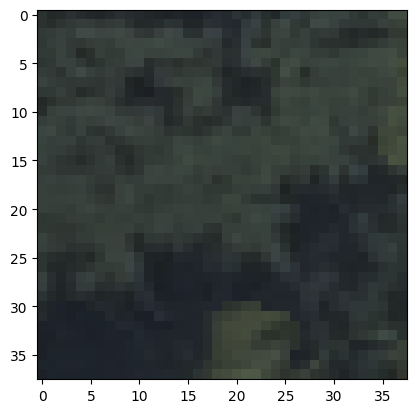

In [10]:
# Generate a random number to extract a spectral image
ind_rand = np.random.randint(0, bia_spec.shape[0])

# Showcase an image of the spectral data
plt.imshow(bia_spec[ind_rand,:,:,0:3]);

### Assign labels as integers to different trees species

As tensorflow prefers integers compared to strings as target values, we transform our labels array. In this array "1" indicates a "Rotbuche", "2" indicates a "Berg-Ahorn", "3" indicates a "Haenge-Birke" and "0" indicates a tree belonging to any other three species.

In [11]:
# New indicator array filled with 0s
lbl_array = np.zeros_like(lbl_array_tmp)

# Loop through each label
for i in range(len(lbl_array_tmp)):
    
    # Assign a 1 if it is a Rotbuche
    if lbl_array_tmp[i] == 'Rotbuche':
        lbl_array[i] = 1

    # Assign a 2 if it is a Berg-Ahorn    
    elif lbl_array_tmp[i] == 'Berg-Ahorn':
        lbl_array[i] = 2

    # Assign a 3 if it is a Haenge-Birke
    elif lbl_array_tmp[i] == 'Haenge-Birke':
        lbl_array[i] = 3
    
# Change the type of the array from "obj" to "int"
lbl_array = lbl_array.astype('int')

---------

---------

## Prepare the data for the model

### Split the data into a train, test and validation set

In [12]:
# Create as many indices as there are trees (irrespective of years)
ind = np.arange(0, len(lbl_array), 1)

# Split the indices into a train and temporary test set
train_ind, test_ind_tmp, train_lbl, test_lbl_tmp = \
    train_test_split(ind, lbl_array, train_size=0.8, stratify=lbl_array, random_state=42)

# Split the temporary test indices once again into a test and validation set
test_ind, val_ind, test_lbl, val_lbl = \
    train_test_split(test_ind_tmp, test_lbl_tmp, train_size=0.5, stratify=test_lbl_tmp, random_state=42)

# Extract images and labels for the train data set using the train indices
train_spec = bia_spec[train_ind,:,:,:]
train_height = bia_height[train_ind,:,:]
train_slope = bia_slope[train_ind]
train_altitude = bia_altitude[train_ind]
train_label = lbl_array[train_ind]

# Extract images and labels for the test data set using the test indices
test_spec = bia_spec[test_ind,:,:,:]
test_height = bia_height[test_ind,:,:]
test_slope = bia_slope[test_ind]
test_altitude = bia_altitude[test_ind]
test_label = lbl_array[test_ind]

# Extract images and labels for the validation data set using the validation indices
val_spec = bia_spec[val_ind,:,:,:]
val_height = bia_height[val_ind,:,:]
val_slope = bia_slope[val_ind]
val_altitude = bia_altitude[val_ind]
val_label = lbl_array[val_ind]

### Perform data augmentation


To deal with the low sample size of the data set, we will create variations of the existing images, called augmentation.

We only perform flips and 90° rotations as other augmentations may interfere with vital information in the image - let's  be crazy and flip and rotate all images in all possible combinations (x12). We first create a function for this:

In [13]:
# Define a function that takes a dataset of images and augments each image
# once in a certain way
def augment_images(img_array):

    # Predefine an array that will contain the augmented images
    img_array_full = np.tile(img_array, (12,1,1,1,1))

    # Loop through each image
    for i in range(img_array.shape[0]):

        # Augmentation number 0: Nothing
        img_aug = img_array_full[0,i]
        img_array_full[0,i] = img_aug

        # Augmentation number 1: 90° rotation        
        img_aug = tf.image.rot90(img_array[i], k=1).numpy()
        img_array_full[1,i] = img_aug

        # Augmentation number 2: 90° rotation + vertical flip
        img_aug = tf.image.rot90(img_array[i], k=1).numpy()
        img_aug = tf.image.flip_up_down(img_aug).numpy()
        img_array_full[2,i] = img_aug

        # Augmentation number 3: 90° rotation + horizontal flip
        img_aug = tf.image.rot90(img_array[i], k=1).numpy()
        img_aug = tf.image.flip_left_right(img_aug).numpy()
        img_array_full[3,i] = img_aug

        # Augmentation number 4: 90° rotation + vertical flip +
        # horizontal flip
        img_aug = tf.image.rot90(img_array[i], k=1).numpy()
        img_aug = tf.image.flip_up_down(img_aug).numpy()
        img_aug = tf.image.flip_left_right(img_aug).numpy()
        img_array_full[4,i] = img_aug

        # Augmentation number 5: 270° rotation
        img_aug = tf.image.rot90(img_array[i], k=3).numpy()
        img_array_full[5,i] = img_aug

        # Augmentation number 6: 270° rotation + vertical flip
        img_aug = tf.image.rot90(img_array[i], k=3).numpy()
        img_aug = tf.image.flip_up_down(img_aug).numpy()
        img_array_full[6,i] = img_aug

        # Augmentation number 7: 90° rotation + horizontal flip
        img_aug = tf.image.rot90(img_array[i], k=3).numpy()
        img_aug = tf.image.flip_left_right(img_aug).numpy()
        img_array_full[7,i] = img_aug

        # Augmentation number 8: 270° rotation + vertical flip +
        # horizontal flip
        img_aug = tf.image.rot90(img_array[i], k=3).numpy()
        img_aug = tf.image.flip_up_down(img_aug).numpy()
        img_aug = tf.image.flip_left_right(img_aug).numpy()
        img_array_full[8,i] = img_aug

        # Augmentation number 9: vertical flip + horizontal flip
        img_aug = tf.image.flip_up_down(img_array[i]).numpy()
        img_aug = tf.image.flip_left_right(img_aug).numpy()
        img_array_full[9,i] = img_aug

        # Augmentation number 10: vertical flip
        img_aug = tf.image.flip_up_down(img_array[i]).numpy()
        img_array_full[10,i] = img_aug

        # Augmentation number 11: horizontal flip
        img_aug = tf.image.flip_left_right(img_array[i]).numpy()
        img_array_full[11,i] = img_aug

        # Report progress
        if (i+1) == img_array.shape[0]:
            print(' - ' + str(100) + 
                '% of all images have been augmented.')
        elif (i%100 == 0) & (i != 0):
            print(' - ' + str(round(100*i/img_array.shape[0])) + 
                '% of all images have been augmented.')
        elif (i%10 == 0) & (i != 0):
            print('.', end='')
        
    # Return the augmented dataset
    return img_array_full


Let´s use the function for augmentation:

In [14]:
# Augment spectral data
print('Started the augmentation of the spectral training images')
train_spec_aug = augment_images(train_spec)
train_spec_aug = np.reshape(train_spec_aug, (-1, train_spec.shape[1], train_spec.shape[2], train_spec.shape[3]))
print('Finished the augmentation of the spectral training images')

# Augment height data (you need to add a singular channel dimension
# as tensorflow's augmentation functions will not function otherwise)
print('\n\nStarted the augmentation of the vegetation height training images')
train_height_aug = augment_images(train_height[:,:,:,np.newaxis])
train_height_aug = np.reshape(train_height_aug, (-1, train_height.shape[1], train_height.shape[2], 1))
print('Finished the augmentation of the vegetation height training images')

# Augment slope data
print('\n\nStarted the "augmentation" of the slope training data')
train_slope_aug = np.tile(train_slope, (12,1))
train_slope_aug = np.reshape(train_slope_aug, (-1))
print('Finished the augmentation of the slope training data')

# Augment altitude data
print('\n\nStarted the "augmentation" of the altitude training data')
train_altitude_aug = np.tile(train_altitude, (12,1))
train_altitude_aug = np.reshape(train_altitude_aug, (-1))
print('Finished the "augmentation" of the altitude training data')

# Augment label data
print('\n\nStarted the "augmentation" of the label training data')
train_lbl_aug = np.tile(train_lbl, (12,1))
train_lbl_aug = np.reshape(train_lbl_aug, (-1))
print('Finished the "augmentation" of the label training data')

Started the augmentation of the spectral training images


2023-10-10 17:08:39.897235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 17:08:39.897713: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


......... - 7% of all images have been augmented.
......... - 15% of all images have been augmented.
......... - 22% of all images have been augmented.
......... - 29% of all images have been augmented.
......... - 37% of all images have been augmented.
......... - 44% of all images have been augmented.
......... - 51% of all images have been augmented.
......... - 59% of all images have been augmented.
......... - 66% of all images have been augmented.
......... - 74% of all images have been augmented.
......... - 81% of all images have been augmented.
......... - 88% of all images have been augmented.
......... - 96% of all images have been augmented.
..... - 100% of all images have been augmented.
Finished the augmentation of the spectral training images


Started the augmentation of the vegetation height training images
......... - 7% of all images have been augmented.
......... - 15% of all images have been augmented.
......... - 22% of all images have been augmented.
......... - 

### Deal with class imbalance

As we have highly imbalanced data with 55% beech trees dominating the dataset, we explored different approaches to deal with imbalanced data. We tested and compared:
- Weighted classes
- Oversampling
- Undersampling

**Oversampling** worked best for our data as there are not enough data overall to perform undersampling. In addition, it seemed that adding weighted classes introduced a further bias that did not diminish the previous bias of a data imbalance.

Here, we will randomly draw from the pool of original and augemented images to increase the sample sizes of the minorty classes, until the same size as for the majority class is reached.

In [15]:
# Calculate the frequency of each class in the data
_, n_all = np.unique(train_lbl_aug, return_counts=True)

# Determine the class with the most data
n_max = np.max(n_all)

# Generate a new array that will contain the over-sampled results
train_spec_ao = train_spec_aug.copy()
train_height_ao = train_height_aug.copy()
train_slope_ao = train_slope_aug.copy()
train_altitude_ao = train_altitude_aug.copy()
train_lbl_ao = train_lbl_aug.copy()

# Loop through all class categories
for i in range(len(n_all)):

    # Extract the frequency of this class
    n_class = n_all[i]

    # Execute this code if this is not the class with the highest
    # frequency
    if (n_class < n_max):

        # Extract only data of this class
        class_spec = train_spec_aug[train_lbl_aug == i]
        class_height = train_height_aug[train_lbl_aug == i]
        class_slope = train_slope_aug[train_lbl_aug == i]
        class_altitude = train_altitude_aug[train_lbl_aug == i]
        class_lbl = train_lbl_aug[train_lbl_aug == i]

        # Generate as many random integers as there are in the class
        # category with the highest frequency minus the number of already
        # existing images for this class category
        rand_ind = np.random.randint(0, len(class_lbl)-1, n_max - n_class)

        # Draw random data from the existing data
        rand_spec = class_spec[rand_ind,:,:,:]
        rand_height = class_height[rand_ind,:,:,:]
        rand_slope = class_slope[rand_ind]
        rand_altitude = class_altitude[rand_ind]
        rand_lbl = class_lbl[rand_ind]

        # Append data to its respective array
        train_spec_ao = np.append(train_spec_ao, rand_spec, axis=0)
        train_height_ao = np.append(train_height_ao, rand_height, axis=0)
        train_slope_ao = np.append(train_slope_ao, rand_slope, axis=0)
        train_altitude_ao = np.append(train_altitude_ao, rand_altitude, axis=0)  
        train_lbl_ao = np.append(train_lbl_ao, rand_lbl, axis=0)

### One hot encoding

In [16]:
# One hot encode the labels
train_lbl_ao_ohe = tf.keras.utils.to_categorical(train_lbl_ao)
test_lbl_ohe = tf.keras.utils.to_categorical(test_lbl)
val_lbl_ohe = tf.keras.utils.to_categorical(val_lbl)

---------

---------

## Create the Ensemble Convolutional Neural Network Model

We will create en ensemble model, that combines different convolutional neural networks for different parts of the data into one. There will be one convolutional neural network for the spectral images and one for the images of the vegetation height. Slope and altitude information will be added as auxiliary information that is not processed by a convolutional neural network. All models and information are eventually fed to a dense network which results in the categorization of the information in either of the four tree species categories.


### Part 1: Define a convolutional neural network for the spectral data

In [17]:
# Create the input layer
input_spec = tf.keras.layers.Input(shape=(train_spec_ao.shape[1], train_spec_ao.shape[2], train_spec_ao.shape[3]))

# Create layer 1
conv1_spec = tf.keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu')(input_spec)
pool1_spec = tf.keras.layers.MaxPooling2D(pool_size=[2,2])(conv1_spec)
drop1_spec = tf.keras.layers.Dropout(0.2)(pool1_spec)

# Create layer 2
conv2_spec = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu')(drop1_spec)
pool2_spec = tf.keras.layers.MaxPooling2D(pool_size=[2,2])(conv2_spec)
drop2_spec = tf.keras.layers.Dropout(0.4)(pool2_spec)

# Create layer 3
conv3_spec = tf.keras.layers.Conv2D(filters=128, kernel_size=[3,3], activation='relu')(drop2_spec)
pool3_spec = tf.keras.layers.MaxPooling2D(pool_size=[2,2])(conv3_spec)
drop3_spec = tf.keras.layers.Dropout(0.4)(pool3_spec)

# Create layer 4
conv4_spec = tf.keras.layers.Conv2D(filters=256, kernel_size=[3,3], activation='relu')(drop3_spec)
drop4_spec = tf.keras.layers.Dropout(0.2)(conv4_spec)

# Create the final flat layer
flat1_spec = tf.keras.layers.Flatten()(drop4_spec)

# Create a model from this structure
model_spec = tf.keras.Model(input_spec, flat1_spec, name="model_spec")

# Show the structure of this model
model_spec.summary()

Model: "model_spec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38, 38, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 36, 36, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2  (None, 18, 18, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 18, 18, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

### Part 2: Define a convolutional neural network for the vegetation height data

In [18]:
# Create the input layer
input_height = tf.keras.layers.Input(shape=(train_height_ao.shape[1],train_height_ao.shape[2], train_height_ao.shape[3]))

# Create layer 1
conv1_height = tf.keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu')(input_height)
pool1_height = tf.keras.layers.MaxPooling2D(pool_size=[2,2])(conv1_height)
drop1_height = tf.keras.layers.Dropout(0.4)(pool1_height)

# Create layer 2
conv2_height = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu')(drop1_height)
pool2_height = tf.keras.layers.MaxPooling2D(pool_size=[2,2])(conv2_height)
drop2_height = tf.keras.layers.Dropout(0.4)(pool2_height)

# Create the final flat layer
flat1_height = tf.keras.layers.Flatten()(drop2_height)

# Create a model from this structure
model_height = tf.keras.Model(input_height, flat1_height, name="model_height")

# Show the structure of this model
model_height.summary()

Model: "model_height"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                 

### Part 3: Define a model input for additional variables that are no images

In [19]:
# Combine the variables into one array
train_aux_ao = np.vstack([train_slope_ao, train_altitude_ao]).T
test_aux = np.vstack([test_slope, test_altitude]).T
val_aux = np.vstack([val_slope, val_altitude]).T

# Create an input layer for auxiliary variables that are directly attached
# to the dense layer
input_aux = tf.keras.layers.Input(shape=(2,))

### Part 4: Combine all models into one

In [20]:
# Concatenate all models from before
cross_speight = tf.keras.layers.concatenate([flat1_spec, flat1_height, input_aux]) 

# Create the dense layer 1
dens1_speight = tf.keras.layers.Dense(units=64, activation='relu')(cross_speight)
drop1_speight = tf.keras.layers.Dropout(.2)(dens1_speight)

# Create the dense layer 2
dens2_speight = tf.keras.layers.Dense(units=32, activation='relu')(drop1_speight)
drop2_speight = tf.keras.layers.Dropout(.4)(dens2_speight)

# Create the dense layer 3
dens3_speight = tf.keras.layers.Dense(units=32, activation='relu')(drop2_speight)
drop3_speight = tf.keras.layers.Dropout(.2)(dens3_speight)

# Create the output layer with four units as there are four tree species
# that need to be predicted
output_speight = tf.keras.layers.Dense(units=4, activation='softmax')(drop3_speight)

# Create the final model
model_speight = tf.keras.models.Model(inputs=[input_spec, input_height, input_aux], outputs=output_speight, name="model_speight")

# Show the structure of this model
model_speight.summary()


Model: "model_speight"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 38, 38, 4)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 36, 36, 32)           1184      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 18, 18, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 18, 18, 32)           0         ['max_pooling2d[0]

 conv2d_5 (Conv2D)           (None, 2, 2, 64)             18496     ['dropout_4[0][0]']           
                                                                                                  
 conv2d_3 (Conv2D)           (None, 1, 1, 256)            295168    ['dropout_2[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)             0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_3 (Dropout)         (None, 1, 1, 256)            0         ['conv2d_3[0][0]']            
                                                                                                  
 dropout_5 (Dropout)         (None, 1, 1, 64)             0         ['max_pooling2d_4[0][0]']     
          

### Part 5: Compile and fit the model

In [21]:
# Compile the model
model_speight.compile(\
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
    metrics=['categorical_accuracy'])

# Fit the model
history_speight = model_speight.fit(\
    x=[train_spec_ao, train_height_ao, train_aux_ao],
    y=train_lbl_ao_ohe,
    epochs=10,
    validation_data=([test_spec, test_height, test_aux], test_lbl_ohe))

Epoch 1/10
1134/1134 [==============================] - 43s 37ms/step - loss: 1.2382 - categorical_accuracy: 0.4516 - val_loss: 1.2034 - val_categorical_accuracy: 0.5000
Epoch 2/10
1134/1134 [==============================] - 35s 31ms/step - loss: 1.1687 - categorical_accuracy: 0.5203 - val_loss: 1.1537 - val_categorical_accuracy: 0.4882
Epoch 3/10
1134/1134 [==============================] - 35s 31ms/step - loss: 1.1381 - categorical_accuracy: 0.5340 - val_loss: 1.2196 - val_categorical_accuracy: 0.4941
Epoch 4/10
1134/1134 [==============================] - 35s 31ms/step - loss: 1.1150 - categorical_accuracy: 0.5520 - val_loss: 1.1801 - val_categorical_accuracy: 0.5294
Epoch 5/10
1134/1134 [==============================] - 34s 30ms/step - loss: 1.0899 - categorical_accuracy: 0.5723 - val_loss: 1.1200 - val_categorical_accuracy: 0.5353
Epoch 6/10
1134/1134 [==============================] - 35s 31ms/step - loss: 1.0723 - categorical_accuracy: 0.5897 - val_loss: 1.1128 - val_categoric

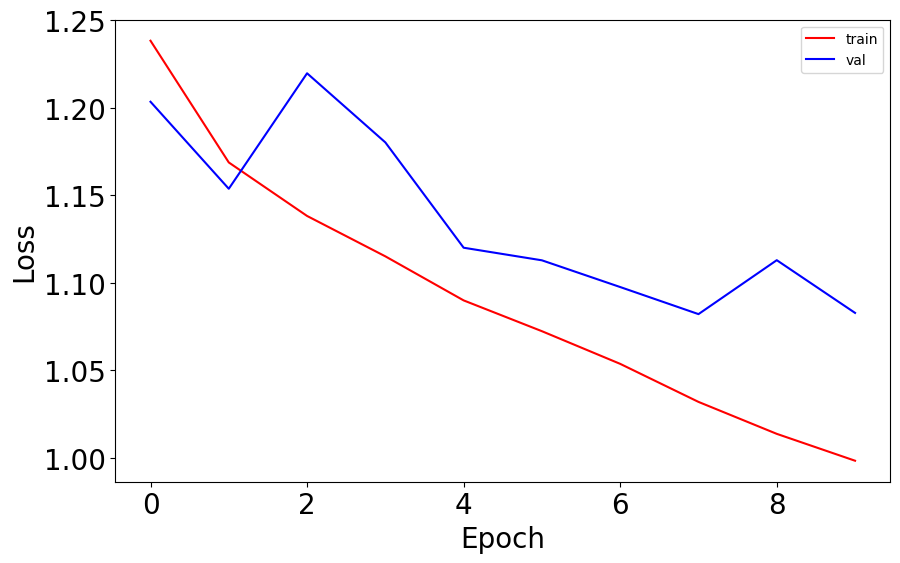

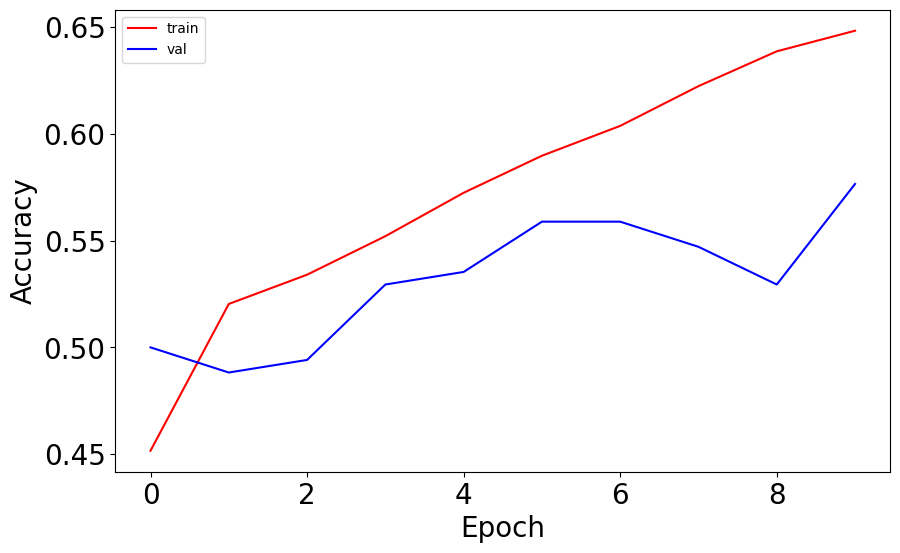

In [22]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_speight.history['loss'], 'r', label='train')
ax.plot(history_speight.history['val_loss'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_speight.history["categorical_accuracy"], 'r', label='train')
ax.plot(history_speight.history['val_categorical_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Part 6: Show the results of the ensemble model

In [24]:
# Evaluate the performance of the model
model_speight.evaluate(x=[val_spec, val_height, val_aux], y=val_lbl_ohe)

6/6 [==============================] - 0s 9ms/step - loss: 1.1046 - categorical_accuracy: 0.5906


[1.1045669317245483, 0.5906432867050171]

In [31]:
# Predict from fitted model
predictions = model_speight.predict([val_spec, val_height, val_aux], verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate class percentages
class_percentages = np.unique(val_lbl, return_counts=True)[1]/len(val_lbl_ohe) * 100

# Calculate predicted class percentages
pred_class_percentages = np.unique(predicted_labels, return_counts=True)[1]/len(predicted_labels) * 100

# Define class names
CLASS_NAMES = ['Other', 'Rotbuche','Berg-Ahorn','Haenge-Birke']

Let´s compare the actural proportions of each class in the original data versus the predicted proportions:

In [32]:
print('Actual proportions')
# Look at class percentages
for class_name, percentage in zip(CLASS_NAMES, class_percentages):
    print(f'{class_name}: {percentage:.2f}%')

print('\n')
print('Predicted proportions')
# Look at predicted class percentages
for class_name, percentage in zip(CLASS_NAMES, pred_class_percentages):
    print(f'{class_name}: {percentage:.2f}%')

Actual proportions
Other: 23.98%
Rotbuche: 55.56%
Berg-Ahorn: 14.62%
Haenge-Birke: 5.85%


Predicted proportions
Other: 18.13%
Rotbuche: 50.29%
Berg-Ahorn: 11.11%
Haenge-Birke: 20.47%


#### Confusion matrix

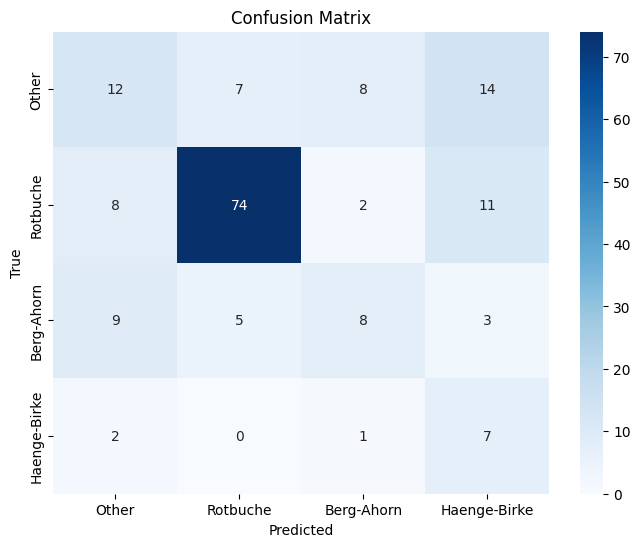

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

# Create matrix
confusion = confusion_matrix(val_lbl, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Classification report
report = classification_report(val_lbl, predicted_labels, target_names=CLASS_NAMES)
print(report)

              precision    recall  f1-score   support

       Other       0.39      0.29      0.33        41
    Rotbuche       0.86      0.78      0.82        95
  Berg-Ahorn       0.42      0.32      0.36        25
Haenge-Birke       0.20      0.70      0.31        10

    accuracy                           0.59       171
   macro avg       0.47      0.52      0.46       171
weighted avg       0.64      0.59      0.61       171



---------

---------

# Additional information

### How well does the trained model work on other datasets?

Here, we test how well our fitted model (that was trained on the data from 2022) can be transferred to another data set.
As an example, we test our fitted model for the data from 2018.

In [ ]:
# Define the path to the data file
data_path = '../images/box_images/baseline/model_images.npz'

# Load the image array containing all box images in a 4D array and their
# labels
with np.load(data_path, allow_pickle=True) as data:
    img_array = data["img_array"]
    labels = data["labels"]

# Extract only none nan values from the year 2018 
img_array = img_array[:,0:1701,:,:,:]
img_array = np.reshape(img_array[[2,2,2,2,2],:,:,:,:], (-1,35,35,4)) ## 2 refers to 2018
height_array = np.reshape(height_array, (-1,11,11))
label_array = np.reshape(labels[:,0:1701], (-1))

# As tensorflow prefers integers compared to strings as target values, we 
# transform our labels array. As a first step, create a new array that
# looks exactly like labels but is filled with zeros
labels_int = np.zeros_like(label_array)

# Loop through each label
for i in range(len(label_array)):
    
    # Assign a 1 if it is a Rotbuche
    if label_array[i] == 'Rotbuche':
        labels_int[i] = 1

    # Assign a 2 if it is a Berg-Ahorn    
    elif label_array[i] == 'Berg-Ahorn':
        labels_int[i] = 2

    # Assign a 3 if it is a Haenge-Birke    
    elif label_array[i] == 'Haenge-Birke':
        labels_int[i] = 3
    
# As the array is still of type "obj", we need to change it to "int"
labels_int = labels_int.astype('int')

In [ ]:
np.unique(labels_int, return_counts=True)

In [ ]:
# Predict from fitted model
predictions = model_speight.predict([img_array, height_array], verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate class percentages
class_percentages = np.unique(labels_int, return_counts=True)[1]/len(labels_int) * 100

# Calculate predicted class percentages
pred_class_percentages = np.unique(predicted_labels, return_counts=True)[1]/len(predicted_labels) * 100

# Define class names
CLASS_NAMES = ['Other', 'Rotbuche','Ahorn','Birke'] # Stimmt die Reihenfolge, Alex?

print('Actual proportions')
# Look at class percentages
for class_name, percentage in zip(CLASS_NAMES, class_percentages):
    print(f'{class_name}: {percentage:.2f}%')

print('\n')
print('Predicted proportions')
# Look at predicted class percentages
for class_name, percentage in zip(CLASS_NAMES, pred_class_percentages):
    print(f'{class_name}: {percentage:.2f}%')

In [ ]:
np.mean(labels_int == predicted_labels)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Create matrix
confusion = confusion_matrix(np.reshape(labels_int, (5,-1))[1,:], np.reshape(predicted_labels, (5,-1))[1,:])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Hyper parameter search for a CNN

One possibility to find the optimal hyper parameters for a model is to use the hyper parameter tuner. We used it, inter alia, to tune the kernel_initializer, the learning rate as well as the filter and dropout rates. We used the hyperband tuning algorithm, which uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.

In [ ]:
#Toolbox for hyperparameter tuning
from kerastuner import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

We have identified a good CNN structure, so we will use this here. 
As the Keras Tuner cannot work with Pooling layers, so they are not included.

In [ ]:
# Create the  model function
def model_builder(hp):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[35,35,4]))
    model.add(tf.keras.layers.Rescaling(1/((2**16)-1)))


    hp_filters1 = hp.Choice('filters1', values=[16, 32, 64]) #32 is best
    hp_dropout1 = hp.Choice('dropout1', values = [0.0, 0.2, 0.4])
    hp_initializer1 = hp.Choice('initializer1', values = ['uniform', 'he_normal','random_normal', 'he_uniform'])
    model.add(tf.keras.layers.Conv2D(filters=hp_filters1, kernel_size=[3, 3], strides=2, kernel_initializer= hp_initializer1, activation='relu'))
    model.add(tf.keras.layers.Dropout(hp_dropout1))

    hp_filters2 = hp.Choice('filters2', values=[64, 128, 256]) #128 is best
    hp_dropout2 = hp.Choice('dropout2', values = [0.3, 0.4, 0.5])
    model.add(tf.keras.layers.Conv2D(filters=hp_filters2, kernel_size=[3, 3], strides=2, kernel_initializer='uniform', activation='relu'))
    model.add(tf.keras.layers.Dropout(hp_dropout2))

    hp_filters3 = hp.Choice('filters3', values=[64, 128, 256]) #128 is best
    hp_dropout3 = hp.Choice('dropout3', values = [ 0.0, 0.2, 0.4])
    model.add(tf.keras.layers.Conv2D(filters=hp_filters3, kernel_size=[3,3], activation='relu'))
    model.add(tf.keras.layers.Dropout(hp_dropout3))


    model.add(tf.keras.layers.Flatten())

    hp_filters4 = hp.Choice('filters4', values=[16, 32, 64])
    hp_dropout4 = hp.Choice('dropout4', values = [ 0.0, 0.2, 0.4])
    model.add(tf.keras.layers.Dense(units=hp_filters4, activation='relu'))
    model.add(tf.keras.layers.Dropout(hp_dropout4))

    model.add(tf.keras.layers.Dense(units=4, activation='softmax')) 


    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

    return model

In [ ]:
# Hyperband determines the number of models to train in a bracket by 
# computing 1 + log factor(max_epochs) and rounding it up to the nearest integer.
tuner = kt.Hyperband(model_builder,
                    objective='val_accuracy',
                    max_epochs=70,
                    factor=3,
                    directory='../data',
                    project_name='CNN_test_initializer_v1') #always change from run to run, otherwise triggered exit

In [ ]:
#tuner.search(img_train, label_train, epochs=70, validation_split=0.2, callbacks=[stop_early]) #for original train data
tuner.search(img_os, label_os, epochs=10, validation_split=0.2, callbacks=[stop_early], verbose = 0) #for oversampled ata 

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]